## Análisis y Predicción de Precios de Autos (Core)

Objetivo: Aplicar técnicas de regresión lineal, KNN y árboles de decisión para predecir precios de autos utilizando un dataset de Kaggle. Realizar un Análisis Exploratorio de Datos (EDA) completo y comparar el rendimiento de los modelos mediante benchmarking.

Dataset: Automobile Dataset

Descripción del Dataset: Este conjunto de datos contiene información detallada sobre diferentes modelos de autos, incluyendo características técnicas y precios. El objetivo es predecir el precio de los autos basándose en sus características.

In [27]:

import pandas as pd
import numpy as np
import utils
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor

## Parte 1: Análisis Exploratorio de Datos (EDA)

###  1. Carga y Exploración de Datos:

In [2]:
# Cargar el dataset proporcionado
file_path = '../../../data/Automobile_data.csv'
automobile_data = pd.read_csv(file_path)

# Mostrar las primeras filas del dataset para revisar su estructura
automobile_data.head().T


,0,1,2,3,4
symboling,3,3,1,2,2
normalized-losses,?,?,?,164,164
make,alfa-romero,alfa-romero,alfa-romero,audi,audi
fuel-type,gas,gas,gas,gas,gas
aspiration,std,std,std,std,std
num-of-doors,two,two,two,four,four
body-style,convertible,convertible,hatchback,sedan,sedan
drive-wheels,rwd,rwd,rwd,fwd,4wd
engine-location,front,front,front,front,front
wheel-base,88.6,88.6,94.5,99.8,99.4


In [3]:
# EDA: Resumen inicial del dataset
eda_summary = {
    "Shape": automobile_data.shape,
    "Column Types": automobile_data.dtypes.value_counts(),
    "Missing Values": automobile_data.isnull().sum(),
    "Columns with Missing Data": automobile_data.isnull().sum()[automobile_data.isnull().sum() > 0]
}

# Revisión rápida de valores únicos por columna para detectar valores extraños o inconsistencias
unique_values = automobile_data.nunique()

# Detectar valores faltantes representados como '?' u otros patrones
missing_like_values = automobile_data.isin(['?', 'NA', 'NaN']).sum()

eda_summary, unique_values, missing_like_values


({'Shape': (205, 26),
  'Column Types': object     16
  int64       5
  float64     5
  Name: count, dtype: int64,
  'Missing Values': symboling            0
  normalized-losses    0
  make                 0
  fuel-type            0
  aspiration           0
  num-of-doors         0
  body-style           0
  drive-wheels         0
  engine-location      0
  wheel-base           0
  length               0
  width                0
  height               0
  curb-weight          0
  engine-type          0
  num-of-cylinders     0
  engine-size          0
  fuel-system          0
  bore                 0
  stroke               0
  compression-ratio    0
  horsepower           0
  peak-rpm             0
  city-mpg             0
  highway-mpg          0
  price                0
  dtype: int64,
  'Columns with Missing Data': Series([], dtype: int64)},
 symboling              6
 normalized-losses     52
 make                  22
 fuel-type              2
 aspiration             2
 num-of-doors

In [4]:
automobile_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205 entries, 0 to 204
Data columns (total 26 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   symboling          205 non-null    int64  
 1   normalized-losses  205 non-null    object 
 2   make               205 non-null    object 
 3   fuel-type          205 non-null    object 
 4   aspiration         205 non-null    object 
 5   num-of-doors       205 non-null    object 
 6   body-style         205 non-null    object 
 7   drive-wheels       205 non-null    object 
 8   engine-location    205 non-null    object 
 9   wheel-base         205 non-null    float64
 10  length             205 non-null    float64
 11  width              205 non-null    float64
 12  height             205 non-null    float64
 13  curb-weight        205 non-null    int64  
 14  engine-type        205 non-null    object 
 15  num-of-cylinders   205 non-null    object 
 16  engine-size        205 non

Descripción de las variables y su distribución.

About Dataset
Context
This dataset consist of data From 1985 Ward's Automotive Yearbook. Here are the sources

Sources:

1) 1985 Model Import Car and Truck Specifications, 1985 Ward's Automotive Yearbook.
2) Personal Auto Manuals, Insurance Services Office, 160 Water Street, New York, NY 10038
3) Insurance Collision Report, Insurance Institute for Highway Safety, Watergate 600, Washington, DC 20037

Content
This data set consists of three types of entities: (a) the specification of an auto in terms of various characteristics, (b) its assigned insurance risk rating, (c) its normalized losses in use as compared to other cars. The second rating corresponds to the degree to which the auto is more risky than its price indicates. Cars are initially assigned a risk factor symbol associated with its price. Then, if it is more risky (or less), this symbol is adjusted by moving it up (or down) the scale. Actuarians call this process "symboling". A value of +3 indicates that the auto is risky, -3 that it is probably pretty safe.

The third factor is the relative average loss payment per insured vehicle year. This value is normalized for all autos within a particular size classification (two-door small, station wagons, sports/speciality, etc…), and represents the average loss per car per year.

Note: Several of the attributes in the database could be used as a "class" attribute.

In [5]:
# Reemplazar '?' por NaN
automobile_data.replace('?', np.nan, inplace=True)

# Convertir columnas numéricas que tienen valores como strings a tipo numérico
columns_to_numeric = ['normalized-losses', 'bore', 'stroke', 'horsepower', 'peak-rpm', 'price']
automobile_data[columns_to_numeric] = automobile_data[columns_to_numeric].apply(pd.to_numeric, errors='coerce')

In [6]:
## Correccion de datos categoricos
categorical_cols =automobile_data.select_dtypes(include=['object']).columns 
for col in categorical_cols:
    automobile_data[col] = automobile_data[col].astype('category')


In [7]:
automobile_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205 entries, 0 to 204
Data columns (total 26 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   symboling          205 non-null    int64   
 1   normalized-losses  164 non-null    float64 
 2   make               205 non-null    category
 3   fuel-type          205 non-null    category
 4   aspiration         205 non-null    category
 5   num-of-doors       203 non-null    category
 6   body-style         205 non-null    category
 7   drive-wheels       205 non-null    category
 8   engine-location    205 non-null    category
 9   wheel-base         205 non-null    float64 
 10  length             205 non-null    float64 
 11  width              205 non-null    float64 
 12  height             205 non-null    float64 
 13  curb-weight        205 non-null    int64   
 14  engine-type        205 non-null    category
 15  num-of-cylinders   205 non-null    category
 16  engine-s

Detección y tratamiento de valores nulos.

In [8]:
## Deteccion de valores nulos
missing_summary = automobile_data.isnull().sum()

missing_summary[missing_summary > 0]

normalized-losses    41
num-of-doors          2
bore                  4
stroke                4
horsepower            2
peak-rpm              2
price                 4
dtype: int64

In [9]:
# Identificar columnas con valores nulos
null_columns = automobile_data.columns[automobile_data.isnull().any()]
automobile_data[null_columns][automobile_data[null_columns].isnull().any(axis=1)]

,normalized-losses,num-of-doors,bore,stroke,horsepower,peak-rpm,price
0,NaN,two,3.47,2.68,111.0,5000.0,13495.0
1,NaN,two,3.47,2.68,111.0,5000.0,16500.0
2,NaN,two,2.68,3.47,154.0,5000.0,16500.0
5,NaN,two,3.19,3.40,110.0,5500.0,15250.0
7,NaN,four,3.19,3.40,110.0,5500.0,18920.0
9,NaN,two,3.13,3.40,160.0,5500.0,NaN
14,NaN,four,3.31,3.19,121.0,4250.0,24565.0
15,NaN,four,3.62,3.39,182.0,5400.0,30760.0
16,NaN,two,3.62,3.39,182.0,5400.0,41315.0
17,NaN,four,3.62,3.39,182.0,5400.0,36880.0


In [10]:
automobile_data[null_columns].describe()

,normalized-losses,bore,stroke,horsepower,peak-rpm,price
count,164.000000,201.000000,201.000000,203.000000,203.000000,201.000000
mean,122.000000,3.329751,3.255423,104.256158,5125.369458,13207.129353
std,35.442168,0.273539,0.316717,39.714369,479.334560,7947.066342
min,65.000000,2.540000,2.070000,48.000000,4150.000000,5118.000000
25%,94.000000,3.150000,3.110000,70.000000,4800.000000,7775.000000
50%,115.000000,3.310000,3.290000,95.000000,5200.000000,10295.000000
75%,150.000000,3.590000,3.410000,116.000000,5500.000000,16500.000000
max,256.000000,3.940000,4.170000,288.000000,6600.000000,45400.000000


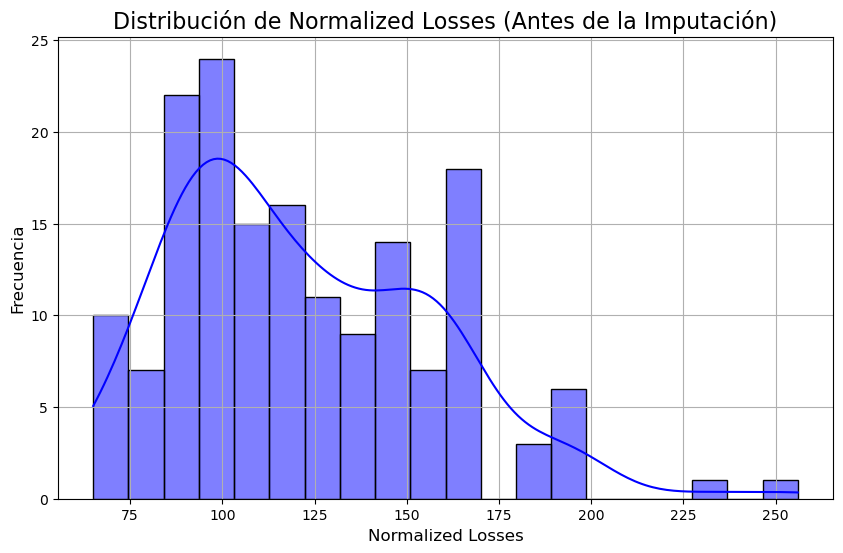

In [11]:
plt.figure(figsize=(10, 6))
sns.histplot(automobile_data['normalized-losses'].dropna(), kde=True, bins=20, color='blue')
plt.title('Distribución de Normalized Losses (Antes de la Imputación)', fontsize=16)
plt.xlabel('Normalized Losses', fontsize=12)
plt.ylabel('Frecuencia', fontsize=12)
plt.grid(True)
plt.show()

In [12]:
# Reemplazar los valores nulos de normalized-losses con la mediana
automobile_data['normalized-losses'].fillna(automobile_data['normalized-losses'].median(), inplace=True)
# Reemplazar los nulos de columnas categoricas con Desconocido 
for col in categorical_cols:
    automobile_data[col] = automobile_data[col].cat.add_categories("Desconocido")
    automobile_data[col].fillna("Desconocido", inplace=True)

C:\Users\Gonzalo\AppData\Local\Temp\ipykernel_29380\3250975847.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  automobile_data['normalized-losses'].fillna(automobile_data['normalized-losses'].median(), inplace=True)
C:\Users\Gonzalo\AppData\Local\Temp\ipykernel_29380\3250975847.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on wh

In [13]:
# Reemplazar el resto de Na con 0
num_text_columns = automobile_data.columns.difference(categorical_cols)
automobile_data[num_text_columns] = automobile_data[num_text_columns].fillna(0)  # o el valor que prefieras


In [14]:
automobile_data.isnull().sum()

symboling            0
normalized-losses    0
make                 0
fuel-type            0
aspiration           0
num-of-doors         0
body-style           0
drive-wheels         0
engine-location      0
wheel-base           0
length               0
width                0
height               0
curb-weight          0
engine-type          0
num-of-cylinders     0
engine-size          0
fuel-system          0
bore                 0
stroke               0
compression-ratio    0
horsepower           0
peak-rpm             0
city-mpg             0
highway-mpg          0
price                0
dtype: int64

Identificación y tratamiento de outliers.

In [15]:
# Identify numerical columns
numerical_columns = automobile_data.select_dtypes(include=[np.number]).columns
# Create a summary DataFrame for outliers
outliers_summary = pd.DataFrame()
for column in numerical_columns:
    outliers = utils.detect_outliers_iqr(automobile_data[column])
    outliers_summary[column] = {
        'Number of Outliers': outliers.sum(),
        'Percentage of Outliers': 100 * outliers.mean(),
        'Lower Bound': automobile_data[column][~outliers].min(),
        'Upper Bound': automobile_data[column][~outliers].max()
    }

# Save the summary to a CSV file
outliers_summary.T

,Number of Outliers,Percentage of Outliers,Lower Bound,Upper Bound
symboling,0.0,0.000000,-2.00,3.00
normalized-losses,8.0,3.902439,65.00,188.00
wheel-base,3.0,1.463415,86.60,114.20
length,1.0,0.487805,144.60,208.10
width,8.0,3.902439,60.30,70.90
height,0.0,0.000000,47.80,59.80
curb-weight,0.0,0.000000,1488.00,4066.00
engine-size,10.0,4.878049,61.00,203.00
bore,4.0,1.951220,2.54,3.94
stroke,13.0,6.341463,2.64,3.86


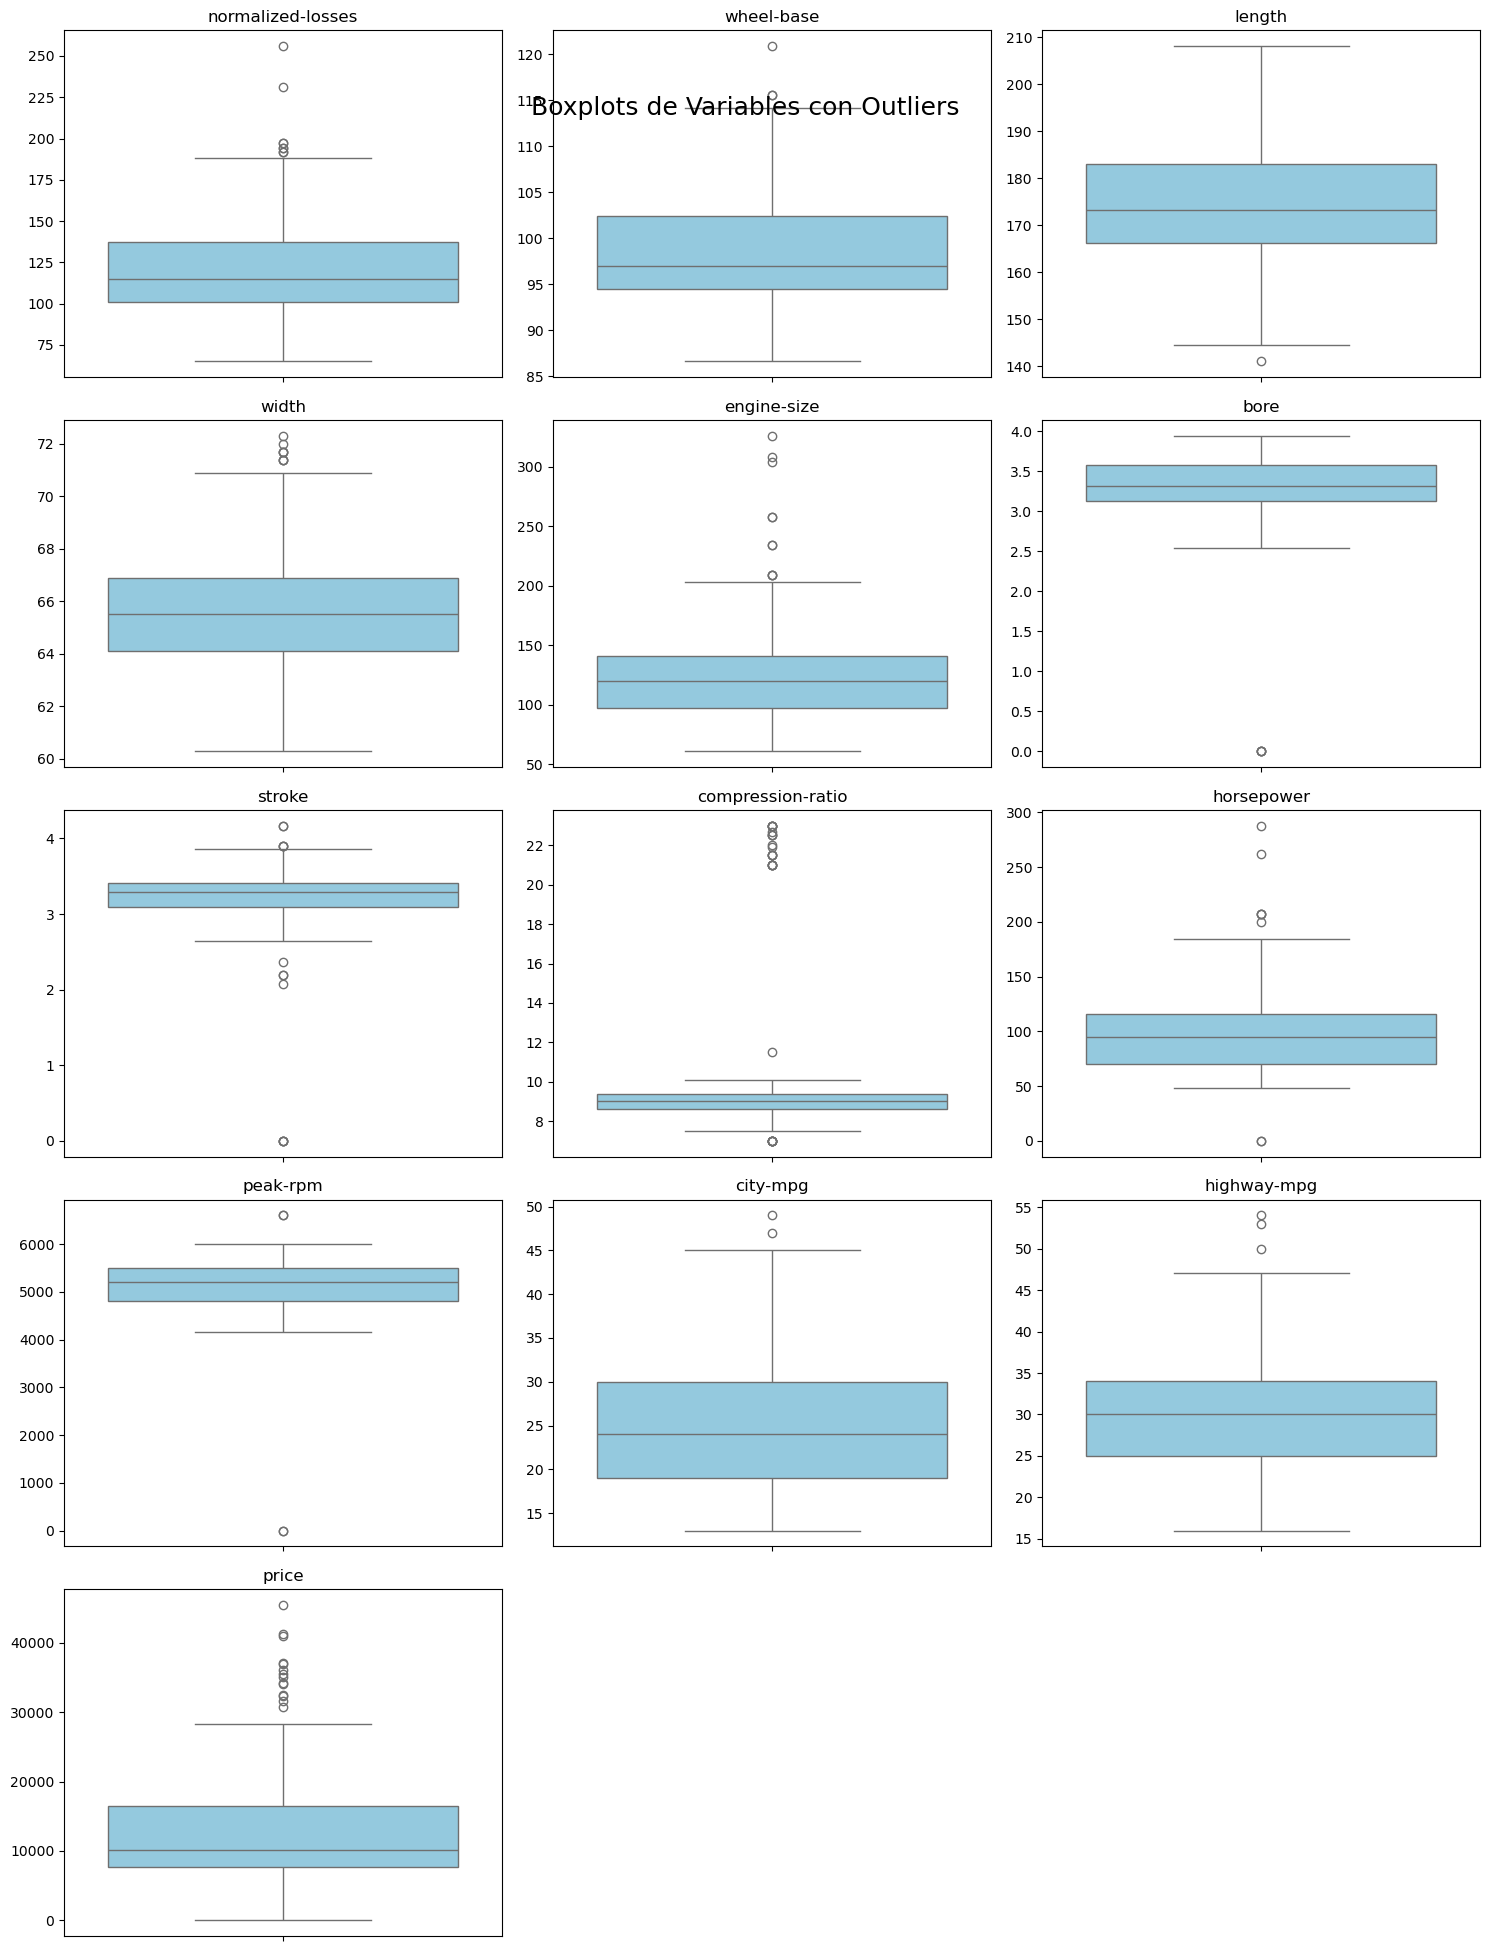

In [16]:
# Variables que contienen outliers según la tabla proporcionada
variables_with_outliers = [
    'normalized-losses', 'wheel-base', 'length', 'width', 
    'engine-size', 'bore', 'stroke', 'compression-ratio', 
    'horsepower', 'peak-rpm', 'city-mpg', 'highway-mpg', 'price'
]

# Crear subplots
fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(15, 20))
fig.suptitle('Boxplots de Variables con Outliers', fontsize=18, y=0.93)

# Plano para iterar
axes = axes.flatten()

# Graficar cada variable con outliers
for i, variable in enumerate(variables_with_outliers):
    sns.boxplot(data=automobile_data, y=variable, ax=axes[i], color='skyblue')
    axes[i].set_title(variable, fontsize=12)
    axes[i].set_ylabel('')

# Eliminar ejes sobrantes si no hay suficientes variables
for j in range(len(variables_with_outliers), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

Se filtraran las filas donde el precio es 0 para hacer sentido de negocio


In [17]:
price_0 = automobile_data[automobile_data['price'] == 0]
price_0


,symboling,normalized-losses,make,fuel-type,aspiration,num-of-doors,body-style,drive-wheels,engine-location,wheel-base,...,engine-size,fuel-system,bore,stroke,compression-ratio,horsepower,peak-rpm,city-mpg,highway-mpg,price
9,0,115.0,audi,gas,turbo,two,hatchback,4wd,front,99.5,...,131,mpfi,3.13,3.40,7.0,160.0,5500.0,16,22,0.0
44,1,115.0,isuzu,gas,std,two,sedan,fwd,front,94.5,...,90,2bbl,3.03,3.11,9.6,70.0,5400.0,38,43,0.0
45,0,115.0,isuzu,gas,std,four,sedan,fwd,front,94.5,...,90,2bbl,3.03,3.11,9.6,70.0,5400.0,38,43,0.0
129,1,115.0,porsche,gas,std,two,hatchback,rwd,front,98.4,...,203,mpfi,3.94,3.11,10.0,288.0,5750.0,17,28,0.0


In [18]:
# Filtrar las filas donde el precio no sea 0
automobile_data = automobile_data[automobile_data['price'] != 0]

print(f"El DataFrame actualizado tiene {automobile_data.shape[0]} filas.")


El DataFrame actualizado tiene 201 filas.


Análisis de correlación entre variables.

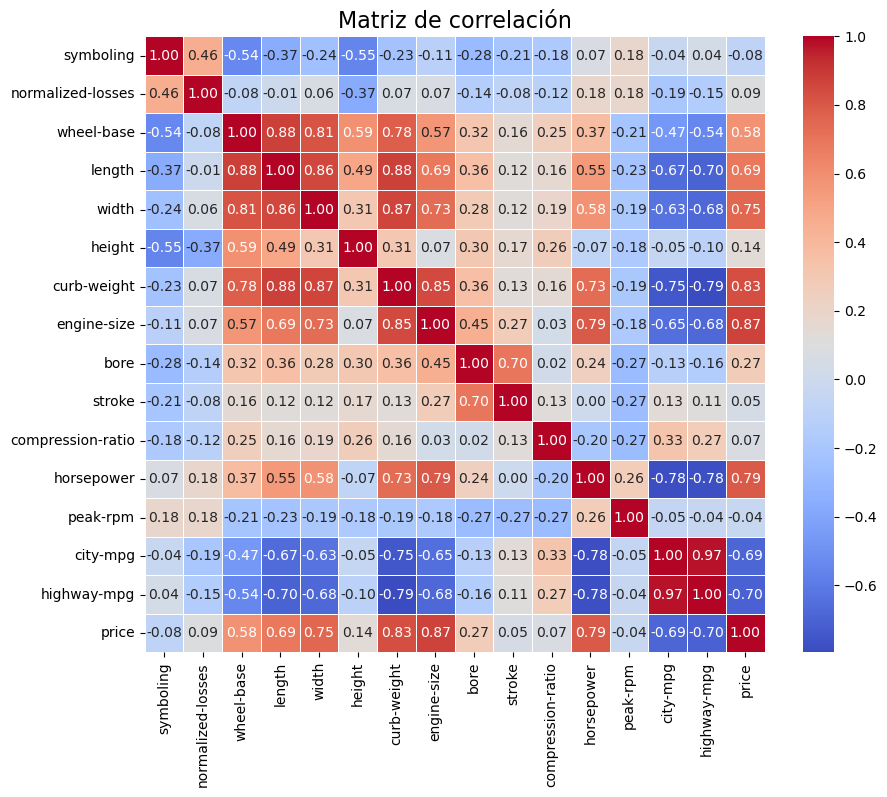

In [19]:
# Calcular la matriz de correlación
# Filtrar solo las columnas numéricas
numeric_columns = automobile_data.select_dtypes(include=['number'])

# Calcular la matriz de correlación
correlation_matrix = numeric_columns.corr()

# Configurar el tamaño del gráfico
plt.figure(figsize=(10, 8))

# Crear el heatmap
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)

# Títulos y ejes
plt.title("Matriz de correlación", fontsize=16)
plt.show()



La matriz muestra que el precio de los automóviles está fuertemente relacionado con el tamaño del motor, el peso del automóvil y la potencia. Sin embargo, el rendimiento del combustible (en ciudad y en carretera) tiene una relación negativa con el precio. Esto podría indicar que los automóviles más caros tienden a ser más potentes y pesados, mientras que los automóviles más eficientes en combustible tienden a ser más baratos.

## Parte 2: Preparación de Datos

###  2. Preprocesamiento:

* Selección de características importantes.
* Transformación de variables categóricas.
* División del conjunto de datos en entrenamiento y prueba.
* Escalado de características.

In [20]:
# Selección de características relevantes
features = ['normalized-losses', 'engine-size', 'curb-weight', 'horsepower',
            'city-mpg', 'highway-mpg', 'compression-ratio', 'bore', 'stroke',
            'peak-rpm', 'make', 'fuel-type', 'body-style', 'drive-wheels',
            'engine-type', 'fuel-system']
target = 'price'

# Filtrar datos
X = automobile_data[features]
y = automobile_data[target]

# Transformar variables categóricas con One-Hot Encoding
categorical_features = ['make', 'fuel-type', 'body-style', 'drive-wheels', 'engine-type', 'fuel-system']
X = pd.get_dummies(X, columns=categorical_features, drop_first=True)

# Escalar características numéricas
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Dividir el conjunto de datos
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)


## Parte 3: Modelos de Regresión

1. Regresión Lineal

In [23]:
# Crear el modelo de regresión lineal
lr_model = LinearRegression()

# Entrenar el modelo
lr_model.fit(X_train, y_train)

# Predecir en el conjunto de prueba
y_pred_lr = lr_model.predict(X_test)

# Evaluación del modelo
mse_lr = mean_squared_error(y_test, y_pred_lr)
r2_lr = r2_score(y_test, y_pred_lr)

print(f"Regresión Lineal - MSE: {mse_lr}, R²: {r2_lr}")

Regresión Lineal - MSE: 8030846.718073371, R²: 0.934359962950182


2. K-Nearest Neighbors (KNN)

In [26]:
# Crear el modelo de KNN
knn_model = KNeighborsRegressor(n_neighbors=5)

# Entrenar el modelo
knn_model.fit(X_train, y_train)

# Predecir en el conjunto de prueba
y_pred_knn = knn_model.predict(X_test)

# Evaluación del modelo
mse_knn = mean_squared_error(y_test, y_pred_knn)
r2_knn = r2_score(y_test, y_pred_knn)

print(f"K-Nearest Neighbors - MSE: {mse_knn}, R²: {r2_knn}")

K-Nearest Neighbors - MSE: 45602264.21658537, R²: 0.6272703965329369


3. Árbol de Decisión

In [28]:
# Crear el modelo de árbol de decisión
dt_model = DecisionTreeRegressor(random_state=42)

# Entrenar el modelo
dt_model.fit(X_train, y_train)

# Predecir en el conjunto de prueba
y_pred_dt = dt_model.predict(X_test)

# Evaluación del modelo
mse_dt = mean_squared_error(y_test, y_pred_dt)
r2_dt = r2_score(y_test, y_pred_dt)

print(f"Árbol de Decisión - MSE: {mse_dt}, R²: {r2_dt}")

Árbol de Decisión - MSE: 16200553.762195121, R²: 0.8675849525573848


## Parte 4: Benchmarking y Comparación de Modelos

In [30]:
# Comparar los resultados de los modelos
results = {
    'Modelo': ['Regresión Lineal', 'KNN', 'Árbol de Decisión'],
    'MSE': [mse_lr, mse_knn, mse_dt],
    'R²': [r2_lr, r2_knn, r2_dt]
}

results_df = pd.DataFrame(results)
print(results_df)


              Modelo           MSE        R²
0   Regresión Lineal  8.030847e+06  0.934360
1                KNN  4.560226e+07  0.627270
2  Árbol de Decisión  1.620055e+07  0.867585


### Discusión sobre las diferencias en el rendimiento de los modelos:
* Regresión Lineal:

    La regresión lineal ofrece el mejor desempeño en términos de MSE y R². Su bajo MSE y su alto R² (0.934) indican que es un modelo que se ajusta muy bien a los datos. Es probable que haya una relación lineal fuerte entre las características predictoras y el precio de los autos, lo que hace que la regresión lineal sea adecuada.
A pesar de su alto rendimiento, la regresión lineal puede ser sensible a problemas de multicolinealidad entre las características o a la presencia de valores atípicos. Sin embargo, en este caso parece funcionar muy bien.
K-Nearest Neighbors (KNN):

- El modelo KNN presenta un MSE mucho más alto y un R² significativamente más bajo (0.627), lo que indica que no captura bien la relación entre las características y el precio de los autos. Este comportamiento puede deberse a que KNN es sensible a la escala de las características, y es posible que no se haya ajustado correctamente el parámetro k.
Además, KNN no ofrece una relación explícita entre las características y el objetivo, lo que lo hace menos interpretativo y posiblemente menos robusto para este tipo de problemas donde se busca una modelización precisa.
Árbol de Decisión:

- El Árbol de Decisión tiene un rendimiento intermedio con un MSE de 1.62e+07 y un R² de 0.868. Aunque no llega a los niveles de la regresión lineal, muestra un desempeño bastante bueno. Es un modelo no lineal, lo que lo hace adecuado para capturar relaciones complejas que no son necesariamente lineales.
Sin embargo, los árboles de decisión pueden ser propensos a sobreajustar (overfitting) si no se controlan adecuadamente los parámetros del modelo (como la profundidad del árbol). En este caso, el rendimiento es suficientemente bueno, pero podrían mejorarse los resultados ajustando esos parámetros.

## Conclusion

Mejor modelo: La Regresión Lineal es claramente el mejor modelo en este conjunto de datos, ya que proporciona el MSE más bajo y el R² más alto. Esto sugiere que las relaciones entre las características y el precio de los autos son principalmente lineales, y el modelo logra capturar esas relaciones de manera precisa.

Modelo subóptimo: El KNN no ofrece buenos resultados en comparación con los otros modelos. Esto podría deberse a la elección subóptima de k o la falta de ajustes en la escala de las características, lo que hace que el modelo no capture correctamente las tendencias en los datos.

Modelo intermedio: El Árbol de Decisión ofrece un buen desempeño pero no supera a la regresión lineal. Su ventaja es que puede manejar relaciones no lineales, pero podría beneficiarse de un ajuste de parámetros más cuidadoso para evitar el sobreajuste.

Interpretación de Resultados
Análisis de cuál modelo es más adecuado:
El modelo más adecuado para este problema es la regresión lineal, debido a su alto R² y bajo MSE. Dado que el precio de los autos está probablemente relacionado con las características de manera lineal, la regresión lineal es una opción natural y efectiva.
El Árbol de Decisión también es adecuado, especialmente si se cree que existen relaciones no lineales entre las variables. Sin embargo, su rendimiento es ligeramente inferior al de la regresión lineal, por lo que no sería la primera opción.
Posibles mejoras y próximos pasos:
Ajuste de hiperparámetros en KNN y Árbol de Decisión:

Para el modelo KNN, se recomienda probar con diferentes valores de k y evaluar el desempeño mediante validación cruzada.
En el Árbol de Decisión, se puede ajustar la profundidad máxima, el número mínimo de muestras por hoja o usar técnicas como la poda para evitar el sobreajuste.
Uso de técnicas avanzadas:

Se podrían explorar modelos más avanzados como Random Forest, Gradient Boosting o XGBoost, los cuales suelen tener un rendimiento superior al de los árboles de decisión y son capaces de manejar relaciones no lineales de manera más eficiente.
Regularización en Regresión Lineal:

Si la regresión lineal muestra signos de sobreajuste, se podría considerar aplicar regularización (como Ridge o Lasso) para mejorar la generalización del modelo.
Análisis de características adicionales:

Incluir características adicionales o transformar las variables actuales (por ejemplo, mediante polinomios o interacciones) podría mejorar el rendimiento de los modelos.